In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
WINDOW_SIZE = 15  # Same as SEQUENCE_LENGTH in your RNN version
# ---------------------

def generate_true_recursive_sine(length=1500):
    omega = 0.15
    coeff = 2 * np.cos(omega)
    seq = [0.5, 0.55]
    for _ in range(length - 2):
        next_val = coeff * (seq[-1] - 0.5) - (seq[-2] - 0.5) + 0.5
        next_val = np.clip(next_val, 0.2501, 0.7499)
        seq.append(next_val)
    return np.array(seq, dtype=np.float32)

full_data = generate_true_recursive_sine(1500)

def create_dataset_lstm(data, k):
    X, y = [], []
    for i in range(len(data) - k):
        # Shape: [sequence_length, input_size=1]
        X.append(data[i : i + k].reshape(-1, 1))
        y.append(data[i + k])
    return torch.tensor(np.array(X)), torch.tensor(np.array(y)).view(-1, 1)

# Training on the first 500 terms
X_train, y_train = create_dataset_lstm(full_data[:500], WINDOW_SIZE)
print(f"LSTM Input Shape (Batch, Seq, Feature): {X_train.shape}")

LSTM Input Shape (Batch, Seq, Feature): torch.Size([485, 15, 1])


In [2]:
class ScalarMemoryLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Final prediction layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, 1]
        # out: [batch, seq_len, hidden_size]
        # hn, cn: final hidden and cell states
        out, (hn, cn) = self.lstm(x)

        # We use the output of the very last time step for prediction
        return self.fc(out[:, -1, :])

model = ScalarMemoryLSTM(input_size=1, hidden_size=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [3]:
epochs = 1000
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.10f}")

Epoch 0, Loss: 0.3358418941
Epoch 200, Loss: 0.0067695859
Epoch 400, Loss: 0.0000201165
Epoch 600, Loss: 0.0000156221
Epoch 800, Loss: 0.0000147946


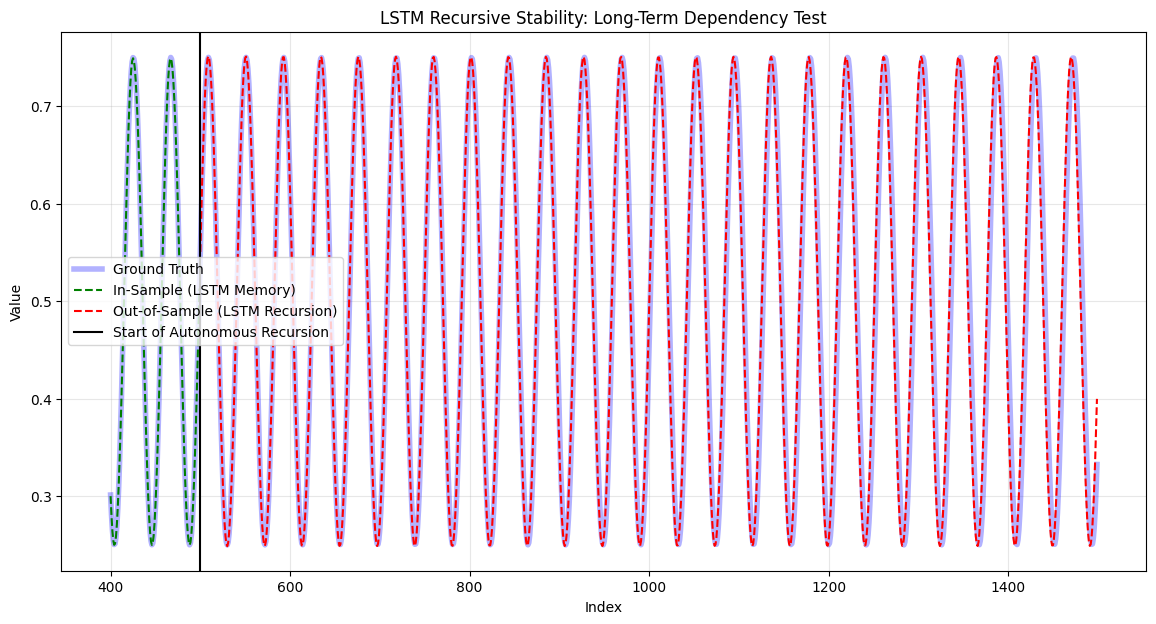

In [4]:
# --- STEP 1: PREDICT LAST 100 OF TRAINING (Indices 400-500) ---
train_preds = []
model.eval()
with torch.no_grad():
    for i in range(400 - WINDOW_SIZE, 500 - WINDOW_SIZE):
        input_seq = X_train[i].unsqueeze(0)
        train_preds.append(model(input_seq).item())

# --- STEP 2: PREDICT 1000 OF TEST DATA (Indices 500-1500) ---
# Start window: the last 15 values of the 500-term training set
current_seq = full_data[500-WINDOW_SIZE:500].reshape(1, WINDOW_SIZE, 1)
future_preds = []

with torch.no_grad():
    for _ in range(1000):
        input_tensor = torch.tensor(current_seq, dtype=torch.float32)
        next_val = model(input_tensor).item()
        future_preds.append(next_val)

        # Create new 3D tensor for concatenation: [1, 1, 1]
        new_val_tensor = np.array([[[next_val]]], dtype=np.float32)
        # Shift: Remove oldest, append newest prediction along axis 1 (sequence)
        current_seq = np.concatenate((current_seq[:, 1:, :], new_val_tensor), axis=1)

# --- STEP 3: PLOTTING ---
plt.figure(figsize=(14, 7))

# Ground Truth
plt.plot(np.arange(400, 1500), full_data[400:1500], label='Ground Truth', color='blue', alpha=0.3, lw=4)

# In-Sample Training Predictions
plt.plot(np.arange(400, 500), train_preds, label='In-Sample (LSTM Memory)', color='green', ls='--')

# Future Recursive Generation
plt.plot(np.arange(500, 1500), future_preds, label='Out-of-Sample (LSTM Recursion)', color='red', ls='--')

plt.axvline(x=500, color='black', label='Start of Autonomous Recursion')
plt.title("LSTM Recursive Stability: Long-Term Dependency Test")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

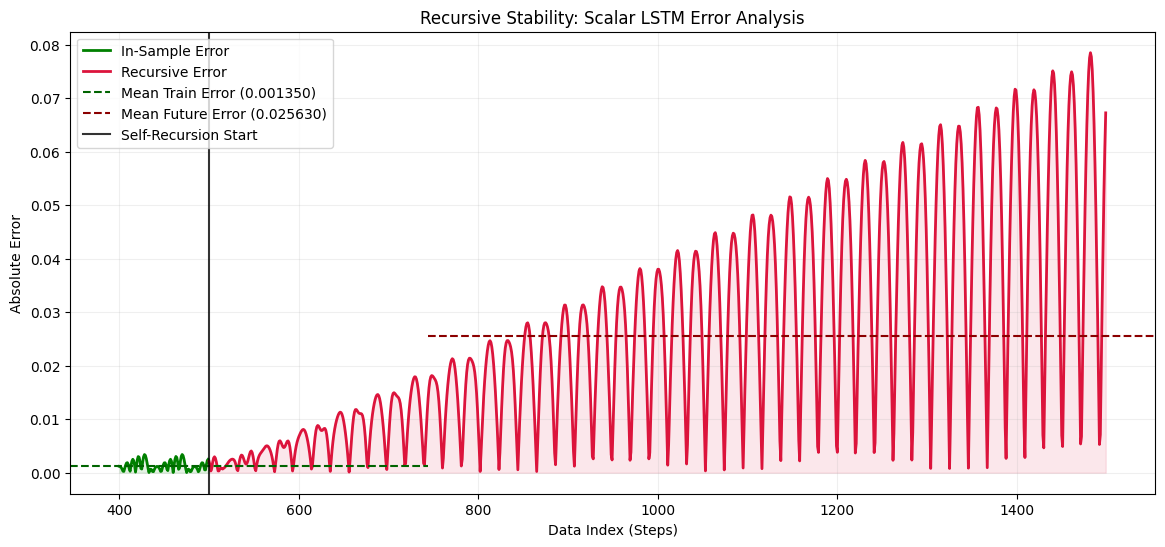

Stability Ratio (Future/Train): 18.99x


In [6]:
error_train = np.abs(np.array(train_preds) - full_data[400:500])
error_future = np.abs(np.array(future_preds) - full_data[500:1500])

mean_train_error = np.mean(error_train)
mean_future_error = np.mean(error_future)

indices = np.arange(400, 1500)
total_error = np.concatenate((error_train, error_future))

# --- STEP 2: PLOTTING ---
plt.figure(figsize=(14, 6))

# Plot the absolute error curves
plt.plot(indices[:100], error_train, color='green', lw=2, label='In-Sample Error')
plt.plot(indices[100:], error_future, color='crimson', lw=2, label='Recursive Error')

# Add the Mean Lines
plt.axhline(y=mean_train_error, xmin=0, xmax=0.33, color='darkgreen', linestyle='--',
            label=f'Mean Train Error ({mean_train_error:.6f})')

plt.axhline(y=mean_future_error, xmin=0.33, xmax=1.0, color='darkred', linestyle='--',
            label=f'Mean Future Error ({mean_future_error:.6f})')

# Fill areas for visual clarity
plt.fill_between(indices[:100], error_train, color='green', alpha=0.1)
plt.fill_between(indices[100:], error_future, color='crimson', alpha=0.1)

# Transition marker
plt.axvline(x=500, color='black', linestyle='-', alpha=0.8, label='Self-Recursion Start')

plt.title("Recursive Stability: Scalar LSTM Error Analysis")
plt.xlabel("Data Index (Steps)")
plt.ylabel("Absolute Error")
plt.grid(True, alpha=0.2)
plt.legend(loc='upper left')

plt.show()

print(f"Stability Ratio (Future/Train): {mean_future_error / mean_train_error:.2f}x")